In [ ]:
import h5py
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def get_images(hdf5_path, patient_id, slice_id):
    with h5py.File(hdf5_path, 'r') as h5f:
        idm = f'{patient_id}'
        img = h5f[f'{idm}/image/{slice_id}'][()]
        mask = h5f[f'{idm}/mask/{slice_id}'][()]
        img_fake = h5f[f'{idm}/image_fake/{slice_id}'][()]
        img_inpaint = h5f[f'{idm}/image_inpaint/{slice_id}'][()]

    return img, mask, img_fake, img_inpaint

def dataframe_from_hdf5(hdf5_path):
    df = {'patient_id': [], 'dataset': [], 'slices': []}
    with h5py.File(hdf5_path, 'r') as h5f:
        patients = list(h5f.keys())
        for idm in patients:
            num_slices = max([int(k) for k in h5f[f'{idm}/image'].keys()])
            dataset = 'colorectal' if 'CRLM-' in idm else '3Dircadb'
            df['patient_id'].append(idm)
            df['dataset'].append(dataset)
            df['slices'].append(num_slices)
    df = pd.DataFrame(df)
    return df

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1KcWCvGoVDVoA44xMitbrb1-NTXbHmjHS/view?usp=sharing -O 'real_and_synthetic_dataset.hdf5'

Downloading...
From (original): https://drive.google.com/uc?id=1lZFvA6dhzZ01Un08DDLwDdPCtse3iRGa
From (redirected): https://drive.google.com/uc?id=1lZFvA6dhzZ01Un08DDLwDdPCtse3iRGa&confirm=t&uuid=38b1db94-2b82-4f39-a8ce-da9551faf56b
To: /content/real_and_synthetic_dataset.hdf5
100% 8.80G/8.80G [01:41<00:00, 86.8MB/s]


In [ ]:
dataset_dir = r'.'
hdf5_path = os.path.join(dataset_dir, 'real_and_synthetic_dataset.hdf5')
df = dataframe_from_hdf5(hdf5_path)
df

,patient_id,dataset,slices
0,3Dircadb1-1,3Dircadb,83
1,3Dircadb1-10,3Dircadb,74
2,3Dircadb1-11,3Dircadb,74
3,3Dircadb1-12,3Dircadb,230
4,3Dircadb1-13,3Dircadb,60
...,...,...,...
429,synthetic_CRLM-CT-1194,colorectal,12
430,synthetic_CRLM-CT-1195,colorectal,22
431,synthetic_CRLM-CT-1196,colorectal,95
432,synthetic_CRLM-CT-1197,colorectal,71


In [ ]:
# se pueden crear otras columnas a partir del nombre para saber si es sintetica o real
df['is_synthetic'] = df['patient_id'].str.contains('synthetic_')
df['original_patient_id'] = df['patient_id'].str.split('_').str[-1]

df

,patient_id,dataset,slices,is_synthetic,original_patient_id
0,3Dircadb1-1,3Dircadb,83,False,3Dircadb1-1
1,3Dircadb1-10,3Dircadb,74,False,3Dircadb1-10
2,3Dircadb1-11,3Dircadb,74,False,3Dircadb1-11
3,3Dircadb1-12,3Dircadb,230,False,3Dircadb1-12
4,3Dircadb1-13,3Dircadb,60,False,3Dircadb1-13
...,...,...,...,...,...
429,synthetic_CRLM-CT-1194,colorectal,12,True,CRLM-CT-1194
430,synthetic_CRLM-CT-1195,colorectal,22,True,CRLM-CT-1195
431,synthetic_CRLM-CT-1196,colorectal,95,True,CRLM-CT-1196
432,synthetic_CRLM-CT-1197,colorectal,71,True,CRLM-CT-1197


In [ ]:
def visualize_real_and_synthetic(N, df, hdf5_path):
    """
    Visualiza N pacientes con imágenes reales y sintéticas.

    Args:
        N (int): Número de pacientes a visualizar.
        df (DataFrame): DataFrame con información de los pacientes.
        hdf5_path (str): Ruta al archivo HDF5.
    """
    # Muestra aleatoria de N pacientes
    samples = df.sample(n=N)

    fig, axes = plt.subplots(2, N, figsize=(16, 8))
    for idx, sample in enumerate(samples.itertuples()):
        patient_id = sample.original_patient_id
        patient_id_synthetic = f'synthetic_{patient_id}'
        slice_id = np.random.randint(0, sample.slices)

        # Obtener imágenes reales y sintéticas
        img, mask, _, _ = get_images(hdf5_path, patient_id, slice_id)
        img_synthetic, mask_synthetic, _, _ = get_images(hdf5_path, patient_id_synthetic, slice_id)

        # Crear imágenes con bordes marcados
        img_mask = mark_boundaries(img, mask)
        img_mask_synthetic = mark_boundaries(img_synthetic, mask_synthetic)

        # Fila 0: Imágenes reales
        axes[0, idx].imshow(img, cmap='gray', vmin=0, vmax=255)
        if idx == 0:
            axes[0, idx].set_ylabel("Real", fontsize=12, rotation=90, labelpad=1)
        axes[0, idx].set_title(f"{patient_id}", fontsize=10)
        axes[0, idx].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # Fila 1: Imágenes sintéticas
        axes[1, idx].imshow(img_synthetic, cmap='gray', vmin=0, vmax=255)
        if idx == 0:
            axes[1, idx].set_ylabel("Synthetic", fontsize=12, rotation=90, labelpad=1)
        axes[1, idx].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
df['dataset'].unique()

array(['3Dircadb', 'colorectal'], dtype=object)

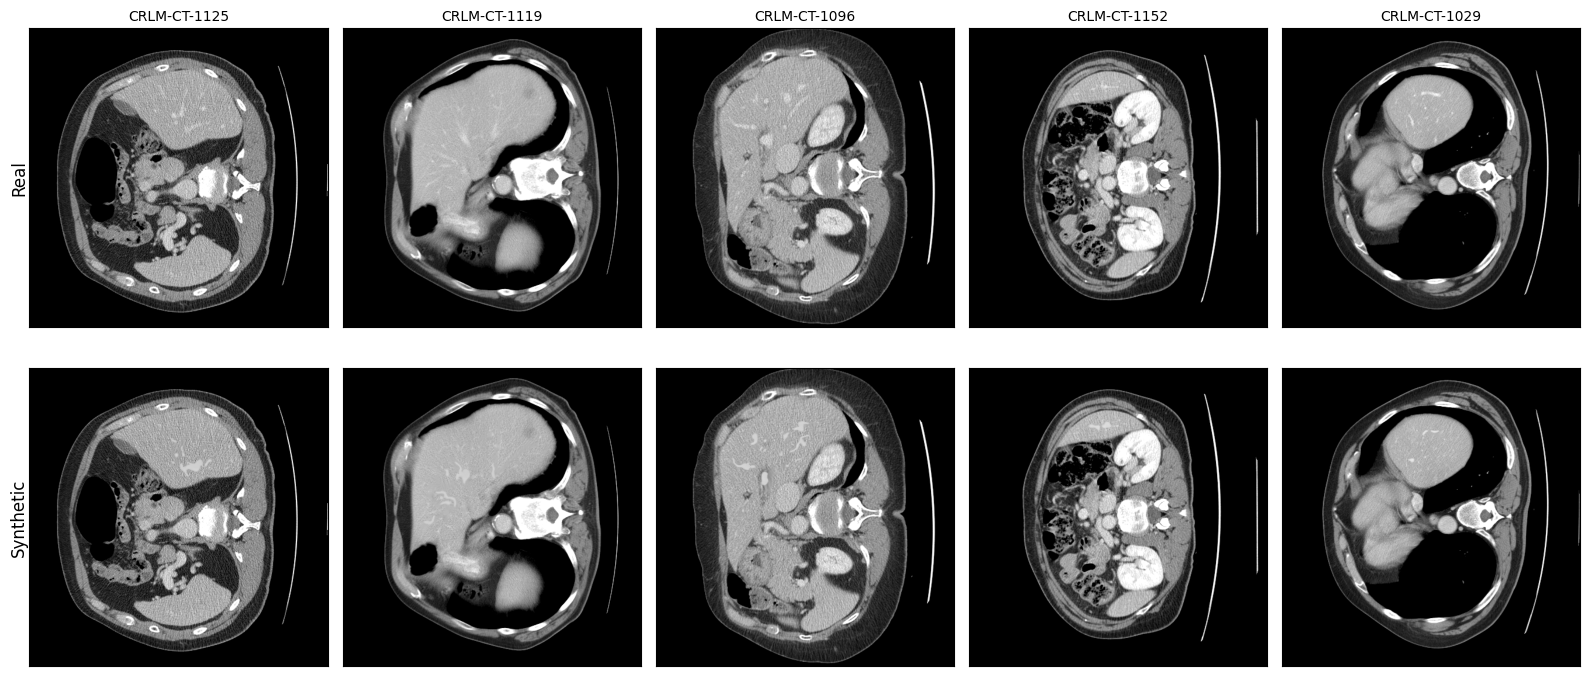

In [ ]:
N = 5  # Número de pacientes a visualizar
visualize_real_and_synthetic(N, df[df['dataset']=='colorectal'], hdf5_path)

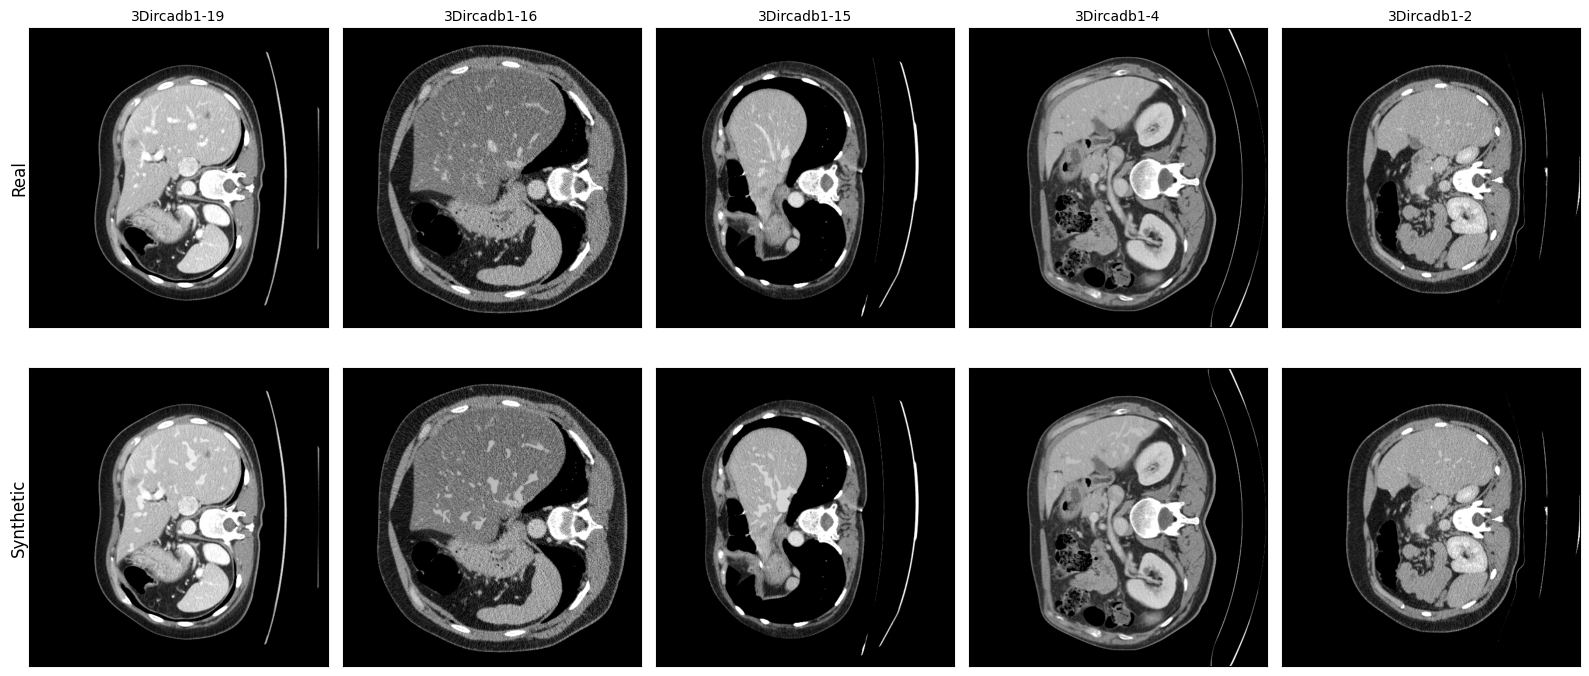

In [ ]:
N = 5
visualize_real_and_synthetic(N, df[df['dataset']=='3Dircadb'], hdf5_path)

<Figure size 640x480 with 0 Axes>

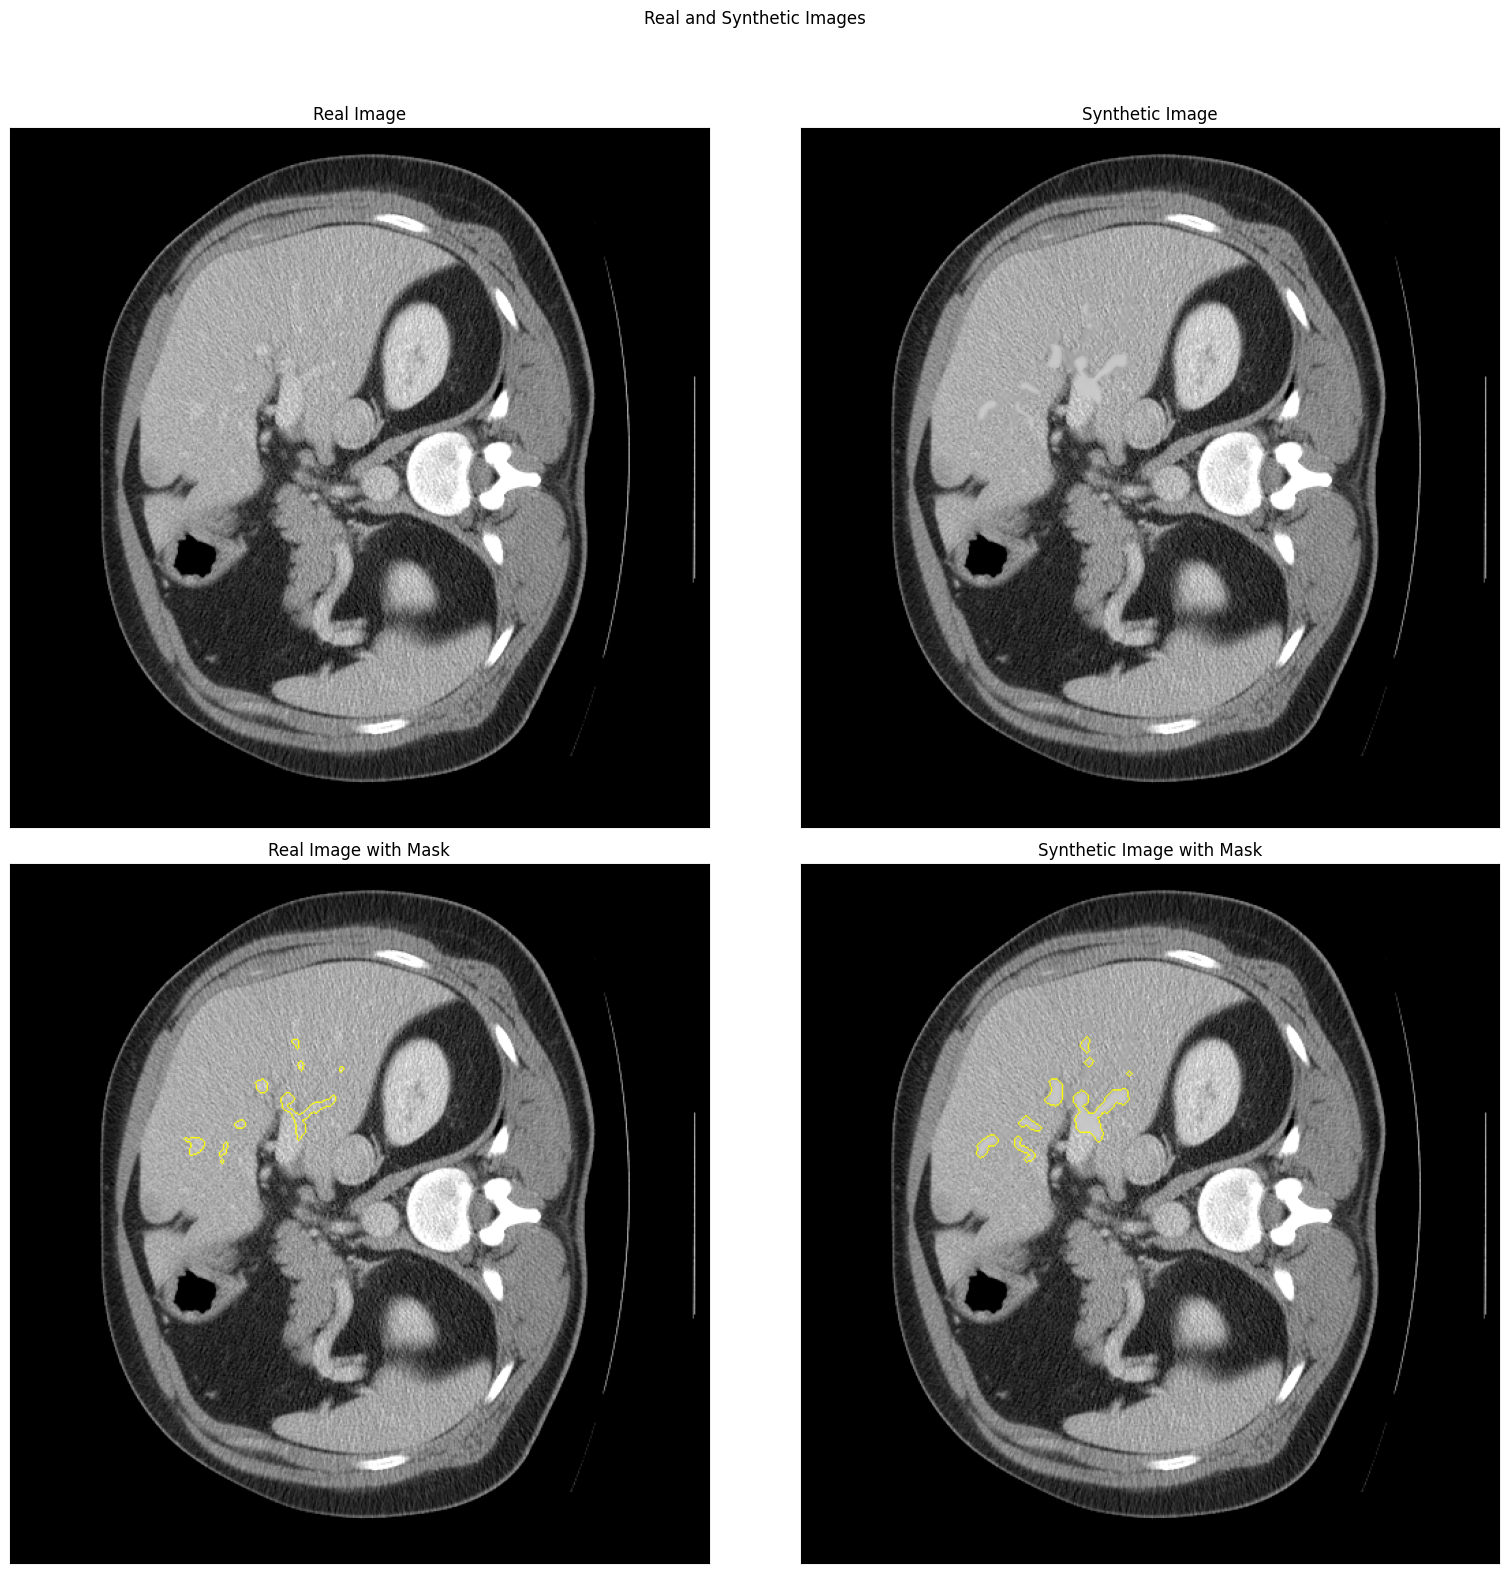

In [ ]:
sample = df.sample(n=1).iloc[0]
patient_id = sample['original_patient_id']
patient_id_synthetic = f'synthetic_{patient_id}'
dataset = sample['dataset']
slice_id = np.random.randint(0, sample['slices'])

img, mask, img_fake, img_inpaint = get_images(hdf5_path, patient_id, slice_id)
img_mask = mark_boundaries(img, mask)

img_synthetic, mask_synthetic, img_fake_synthetic, img_inpaint_synthetic = get_images(hdf5_path, patient_id_synthetic, slice_id)
img_mask_synthetic = mark_boundaries(img_synthetic, mask_synthetic)

plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[0, 0].set_title("Real Image")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 1].imshow(img_synthetic, cmap='gray', vmin=0, vmax=255)
ax[0, 1].set_title("Synthetic Image")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(img_mask, cmap='gray', vmin=0, vmax=255)
ax[1, 0].set_title("Real Image with Mask")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].imshow(img_mask_synthetic, cmap='gray', vmin=0, vmax=255)
ax[1, 1].set_title("Synthetic Image with Mask")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.suptitle(f'Real and Synthetic Images')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()